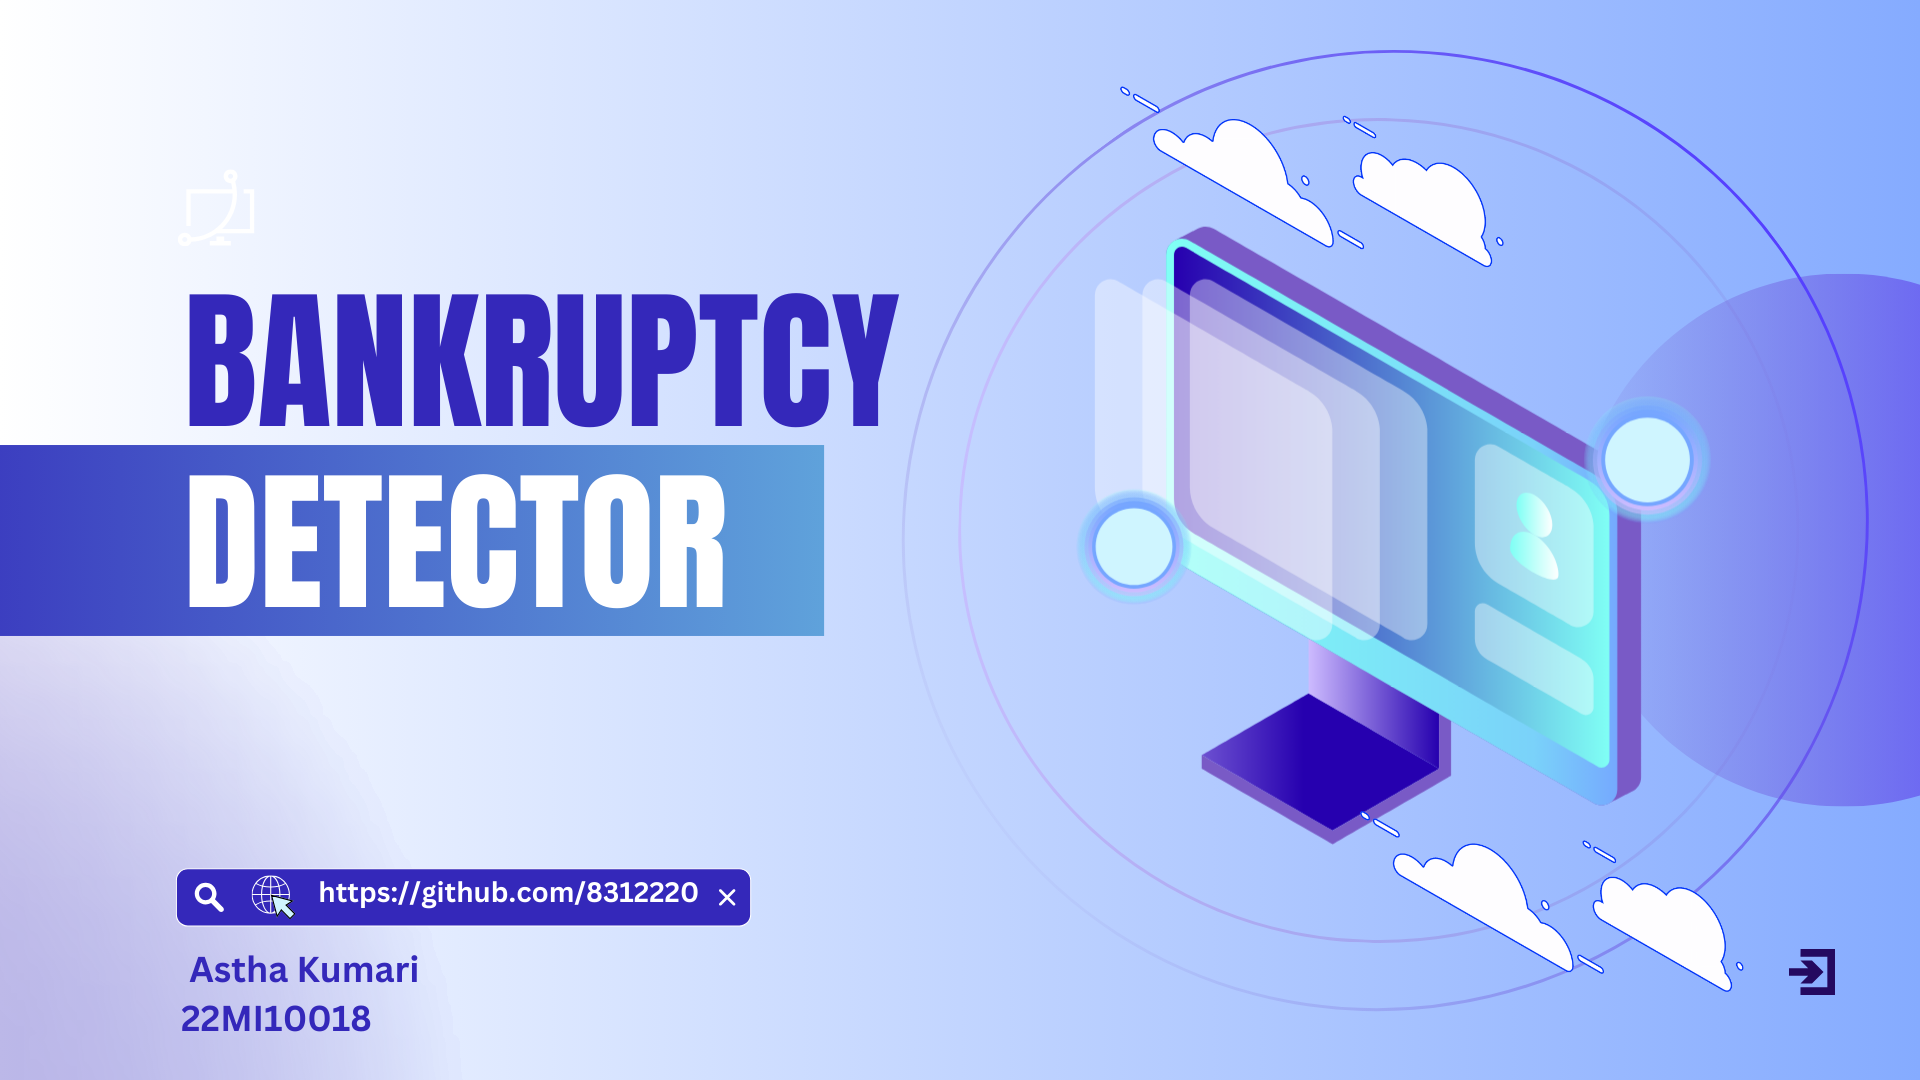

In [3]:
from IPython.display import Image
Image(filename='Cover.png')



## Contents  
<ol>
    <b><li>Importing libraries</li></b>
    <li><b>Importing and organizing the data</b>
        <ol>
            <li>Convert the columns types for the features to float</li>
            <li>Convert the class label types to int</li>
        </ol>
    </li>
    <li><b>Data Analysis and Preprocessing</b>
        <ol>
            <li>Missing Data Analysis
                <ol>
                    <li>Generate Sparsity Matrix for the missing data</li>
                    <li>Generate Heat Map for the missing data</li>
                </ol>
            </li>
            <li>Data Imputation
                <ol>
                    <li>Mean Imputation</li>
                    <li>K-NN</li>
                    <li>EM</li>
                    <li>MICE</li>
                </ol>
            </li>
            <li>Dealing with imbalanced data
                <ol>
                    <li>Oversampling with SMOTE</li>
                </ol>
            </li>
        </ol>
    </li>
    <li><b>Data Modeling</b>
        <ol>
            <li>K-Fold Cross validation</li>
            <li>Models
                <ol>
                    <li>Gaussian Naive Bayes classifier</li>
                    <li>Logistic Regression classifier</li>
                    <li>Decision Tree classifier</li>
                    <li>Random Forest classifier</li>
                    <li>Extreme Gradient Boosting classifier</li>
                    <li>Balanced Bagging classifier</li>
                </ol>
            </li>
        </ol>
    </li>
    <li><b>Model Analysis</b>
        <ol>
            <li>Model ranking</li>
            <li>Balanced Bagging: Effect of varying number of estimators on the accuracy scores on different datasets</li>
            <li>Balanced Bagging: Plotting effect of number of estimators on Accuracy</li>
        </ol>
    </li>
    <li><b>References</b></li>
</ol>

## 1. Importing libraries

In [ ]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
%matplotlib inline

# For loading .arff files
from scipy.io import arff

# To analyze the type of missing data
import missingno as msno

import fancyimpute
import impyute as impy
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from collections import Counter
from collections import OrderedDict

# Library imbalanced-learn to deal with the data imbalance. To use SMOTE oversampling
from imblearn.over_sampling import SMOTE 

# classification models
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

## 2. Importing and organizing the data

<b>Dataset Link:</b>The Dataset can be found at [Polish bankruptcy dataset](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data)

There are a total of **5 .arff data files** with the names **`1year`, `2year`, `3year`, `4year`, `5year`**.   
Load the .arff files and convert them into pandas dataframes using the `load_dataframes` function.   
Give them new columns headers using the function `set_new_headers`. The column labels for the features are like `X1`, `X2`, ... , `X64`. The class label is `Y`.   
Print the first 5 rows of a dataframe, to see how the data looks like.

In [ ]:

def load_arff_raw_data():
    N=5
    return [arff.loadarff('data/' + str(i+1) + 'year.arff') for i in range(N)]

def load_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()]

def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('Y')
    for df in dataframes:
        df.columns = cols

dataframes = load_dataframes()

set_new_headers(dataframes)    

dataframes[0].head()

#### 2.A Convert the columns types for the features to float
The numeric data shown in the dataframe above is infact a python object. Let us convert all the numberic features for all the dataframes into float to maintain consistency.

In [ ]:
# Convert the dtypes of all the columns (other than the class label columns) to float.
def convert_columns_type_float(dfs):
    for i in range(5):
        index = 1
        while(index<=63):
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dfs[i][colname] = col.astype(float)
            index+=1
            
convert_columns_type_float(dataframes)            

#### 2.B Convert the class label types to int
If we look the class label `Y`, we notice that the values are shown either as `b'0'` or `b'1'`   
They actually correspond to bankruptcy being false and true respectively.   
It is convenient to convert them to binary integers 0 and 1 respectively.

In [ ]:
# The class labels for all the dataframes are originally in object type. Convert them to int types
def convert_class_label_type_int(dfs):
    for i in range(len(dfs)):
        col = getattr(dfs[i], 'Y')
        dfs[i]['Y'] = col.astype(int)
        
convert_class_label_type_int(dataframes)

## 3. Data Analysis and Preprocessing

### 3.A Missing Data Analysis
Surely, there is missing data. Let us now see how much of it is missing

In [ ]:

def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = [df.dropna(axis=0, how='any') for df in dataframes]
    if verbose:
        for i in range(len(dataframes)):
            print(str(i+1)+'year:','Original Length=', len(dataframes[i]), '\tCleaned Length=', len(clean_dataframes[i]), '\tMissing Data=', len(dataframes[i])-len(clean_dataframes[i]))
    return clean_dataframes

nan_dropped_dataframes = drop_nan_rows(dataframes, verbose=True)

The above step shows us that there are a lot of rows in each of the 5 dataframes which have missing data in at least one of the features. In most of these dataframes, the missing-data-rows correspond to more than 50% of the entire data.   

#### 3.A.a Generate Sparsity Matrix for the missing data
Now that we have established that there is a lot of missing data, let us find out if the missing data has some correlation.   
The `matrix` function from the `missingno` library helps us generate sparsity matrix, which shows us the gaps in the data.

In [ ]:
# generate the sparsity matrix (figure) for all the dataframes
def generate_sparsity_matrix(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.matrix(dfs[i][missing_df_i], figsize=(20,5))

generate_sparsity_matrix(dataframes)

From the above plots of sparsity for all the 5 dataframes, we could notice a lot of sparsity for the feature `X37` has the highest sparsity among all the features for all the dataframes. The feature `X21` is sparse for some, if not all, dataframes. Also, more or less, all the features have missing data samples.   

From the above sparsity-plot, we could only know how sparse the data is, yet we don't know if the data missing-ness is correlated among any features, i.e., is the data missing completely at random? Or are there any features that are missing together? as a next step, let us find out if there is some correlation among the features.

However, by now it is clear that simply dropping all the rows with missing values, or eliminating all the features which have missing values is not a good approach of dealing with the missing data, as it leads to tremendous data loss.

#### 3.A.b Generate Heat Map for the missing data   
Now, let us find out if there is some correlation among the missing features.    

Using the `heatmap` function from `missingno` library, let us plot the heatmaps for all the dataframes.

In [ ]:

def generate_heatmap(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.heatmap(dfs[i][missing_df_i], figsize=(20,20))
        
generate_heatmap(dataframes)        

The heat maps above, for all the 5 dataframes, describe the degree of nullity relationship between different features.    The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1).    
Features with no missing value are excluded in the heatmap. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed.    

A perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values.       

A perfect negative nullity correlation (R=-1) means that one of the features is missing and the second is not missing.   

The takeaway is that, in each dataframe, there are some features that are heavily correlated (R = 1 or -1) and also there are features that are not essentially correlated (R values close to 0)

### 3.B Data Imputation

It is now established that we need to impute (fill in the gaps) the missing data, as dropping the missing rows or eliminating the missing features is not an option.   

We would like to explore some of the widely used missing data imputation techniques.   
<b>
1. Mean Imputation (baseline method)
2. k Nearest Neighbors (k-NN) Imputation
3. Expectation-Maximization (EM) Imputation
4. Multivariate Imputation using Chained Equations (MICE)
</b>

#### 3.B.a Mean Imputation

In [ ]:
def perform_mean_imputation(dfs):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
    imputer = Imputer(missing_values=np.nan, strategy='mean', axis=0)
    mean_imputed_dfs = [pd.DataFrame(imputer.fit_transform(df)) for df in dfs]
    for i in range(len(dfs)):
        mean_imputed_dfs[i].columns = dfs[i].columns   
    return mean_imputed_dfs

mean_imputed_dataframes = perform_mean_imputation(dataframes)

#### 3.B.b k-Nearest Neighbors (k-NN) Imputation

In [ ]:
def perform_knn_imputation(dfs):
    knn_imputed_datasets = [fancyimpute.KNN(k=100,verbose=True).complete(dfs[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=knn_imputed_datasets[i]) for i in range(len(dfs))]
    
knn_imputed_dataframes = perform_knn_imputation(dataframes)
set_new_headers(knn_imputed_dataframes)

#### 3.B.c Expectation-Maximization (EM) Imputation

In [ ]:
def perform_EM_imputation(dfs):
    em_imputed_datasets = [impy.imputations.cs.em(dfs[i].values, loops=50, dtype='cont') for i in range(len(dfs))]
    return [pd.DataFrame(data=em_imputed_datasets[i]) for i in range(len(dfs))]

em_imputed_dataframes = perform_EM_imputation(dataframes)
set_new_headers(em_imputed_dataframes)

#### 3.B.d MICE imputation (Multivariate Imputation using Chained Equation)
Obtaining the completed features for all the 5 dataframes by doing MICE (Multiple Imputation from Chained Equations)

In [ ]:
def perform_MICE_imputation(dfs):
    mice_imputed_datasets = [fancyimpute.MICE(verbose=False).complete(dfs[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=mice_imputed_datasets[i]) for i in range(len(dfs))]
    
mice_imputed_dataframes = perform_MICE_imputation(dataframes)
set_new_headers(mice_imputed_dataframes)

In the above 4 steps, we have successfully created 4 differently imputed dataframes using: Mean, k-NN, EM and MICE techniques respectively.   

Here below, we create a dictionary of all the imputed dataframes to re-use them in the future. 

In [ ]:
imputed_dataframes_dictionary = OrderedDict()
imputed_dataframes_dictionary['Mean'] = mean_imputed_dataframes
imputed_dataframes_dictionary['k-NN'] = knn_imputed_dataframes
imputed_dataframes_dictionary['EM'] = em_imputed_dataframes
imputed_dataframes_dictionary['MICE'] = mice_imputed_dataframes

### ---------------------------------------------------------------------------------------------------------------------------------------------------------

### 3.C Dealing with imbalanced data   

In the steps seen above, we have successfully dealt with the missing data. But we have not dealt with the class imbalance (if any) in the data. Simply put, Data Imbalance is a condition where the samples belonging to one or more 'majority' class labels of a labelled dataset heavily outnumber the sample belonging to the other 'minority' classes.   

Data imbalance critically affects the modeling as the models won't have sufficient data belonging to minority classes to train on and this leads to biased models, ultimately leading to poor performance on test data.   

Firstly, let us see if our data is imbalanced, and to what extent.

In [ ]:
def check_data_imbalance(dfs):
    for i in range(len(dfs)):
        print('Dataset: '+str(i+1)+'year')
        print(dfs[i].groupby('Y').size())
        minority_percent = (dfs[i]['Y'].tolist().count(1) / len(dfs[i]['Y'].tolist()))*100
        print('Minority (label 1) percentage: '+  str(minority_percent) + '%')
        print('-'*64)
        
check_data_imbalance(dataframes)

We have seen in the step above that there is a lot of data imbalance for our datasets, as indicated by the percentage of minority class (label `1`) samples among their datasets. With this huge magnitude of data imbalance, the models will not train wel if we leave them as is. 

#### 3.C.a Oversampling with SMOTE (Synthetic Minority Over Sampling Technique)
First, we Split the features and labels into separate dataframes for all the original dataframes. Then, we will perform the SMOTE oversampling from given dataframes.

In [ ]:
def split_dataframes_features_labels(dfs):
    feature_dfs = [dfs[i].iloc[:,0:64] for i in range(len(dfs))]
    label_dfs = [dfs[i].iloc[:,64] for i in range(len(dfs))]
    return feature_dfs, label_dfs

def oversample_data_SMOTE(dfs, verbose=False):
    smote = SMOTE(ratio='auto' , random_state=42, k_neighbors=10)
    #Split the features and labels for each dataframe
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    resampled_feature_arrays = []
    resampled_label_arrays = []
    for i in range(len(dfs)):
        if verbose: print('Dataset: ' + str(i+1) + 'year:')
        if verbose: print('Original dataset shape {}'.format(Counter(label_dfs[i])))
        dfi_features_res, dfi_label_res = smote.fit_sample(feature_dfs[i], label_dfs[i])
        if verbose: print('Resampled dataset shape {}\n'.format(Counter(dfi_label_res)))   
        resampled_feature_arrays.append(dfi_features_res)
        resampled_label_arrays.append(dfi_label_res)        
    return resampled_feature_arrays, resampled_label_arrays

# Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them. Also re-assign the columns headers.
def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs = []
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        label_df.columns=['Y'] 
        resampled_dfs.append(feature_df.join(label_df))
    set_new_headers(resampled_dfs)    
    return resampled_dfs

# Perform SMOTE oversampling on all the imputed dataframes, and return them in a dictionary.
def perform_oversampling_on_imputed_dataframes(df_dict):
    imputed_oversampled_dataframes_dictionary = OrderedDict()
    for key,dfs in df_dict.items():
        print('SMOTE Oversampling for ' + key + ' imputed dataframes\n')
        smote_feature_arrays, smote_label_arrays = oversample_data_SMOTE(dfs, verbose=True)
        oversampled_dataframes = restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)
        imputed_oversampled_dataframes_dictionary[key] = oversampled_dataframes
        print('-'*100)
    return imputed_oversampled_dataframes_dictionary

imputed_oversampled_dataframes_dictionary = perform_oversampling_on_imputed_dataframes(imputed_dataframes_dictionary)

## 4. Data Modeling: Building Classification Models

### 4.A K-Fold Cross Validation

In [ ]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=False, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

### 4.B MODELS

### 4.B.a Gaussian Naive Bayes classifier

In [ ]:

gnb_classifier = GaussianNB()

### 4.B.b Logistic Regression classifier

In [ ]:
lr_classifier = LogisticRegression(penalty = 'l1', random_state = 0)

### 4.B.c Decision Tree Classifier

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)

### 4.B.d Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')

### 4.B.e Extreme Gradient Boosting Classifier

In [ ]:
xgb_classifier = XGBClassifier()

### 4.B.f Balanced Bagging Classifier

In [ ]:
bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), n_estimators = 5, bootstrap = True)

Creating a dictionary of models


In [ ]:
models_dictionary = OrderedDict()

models_dictionary['Gaussian Naive Bayes'] = gnb_classifier
models_dictionary['Logistic Regression'] = lr_classifier
models_dictionary['Decision Tree'] = dt_classifier
models_dictionary['Extreme Gradient Boosting'] = xgb_classifier
models_dictionary['Random Forest'] = rf_classifier
models_dictionary['Balanced Bagging'] = bb_classifier

perform data modeling

In [ ]:

def perform_data_modeling(_models_, _imputers_, verbose=False, k_folds=5):
    
    # 7 Models
    # 4 Imputers
    # 5 datasets (for 5 years)
    # 7 metrics, averaged over all the K-Folds
    model_results = OrderedDict()
    

    for model_name, clf in _models_.items():
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the different imputed_data mechanisms (Mean, k-NN, EM, MICE)
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list)            
            
            year_results = OrderedDict()
            
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index+1) + 'year' + '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                metrics_results = OrderedDict()
                accuracy_list = np.zeros([k_folds])
                precision_list = np.zeros([k_folds,2])
                recall_list = np.zeros([k_folds,2])
                TN_list = np.zeros([k_folds])
                FP_list = np.zeros([k_folds])
                FN_list = np.zeros([k_folds])
                TP_list = np.zeros([k_folds])                
                
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    y_test = y_test_list[k_index]
                    
                    clf = clf.fit(X_train, y_train)
                    y_test_predicted = clf.predict(X_test)
                    
                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list[k_index] = _accuracy_
                    
                    _recalls_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list[k_index] = _recalls_
                    
                    _precisions_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list[k_index] = _precisions_
                    
                    _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
                    TN_list[k_index] = _confusion_matrix_[0][0]
                    FP_list[k_index] = _confusion_matrix_[0][1]
                    FN_list[k_index] = _confusion_matrix_[1][0]
                    TP_list[k_index] = _confusion_matrix_[1][1]
                
                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                
                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                
                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results                

In [ ]:
results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)

## Model Analysis

### Model Ranking
model -> imputer -> year

In [ ]:
def perform_model_ranking(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_accuracy = 0
            for year, metrics in imputer_details.items():
                mean_accuracy += metrics['Accuracy']
            mean_accuracy = mean_accuracy/len(imputer_details)
            row.append(mean_accuracy)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

In [ ]:
perform_model_ranking(models_dictionary, imputed_oversampled_dataframes_dictionary, results)

### Balanced Bagging: Effect of varying number of estimators on the accuracy scores on different datasets

This list stores results of Balanced Bagging classifier obtained by running it for 
various values of number of estimators in the range of 1 to 30

In [ ]:

results_by_estimators = []
for i in range(29):
    models_dictionary['Balanced Bagging'] = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), n_estimators = i+1, bootstrap = True)
    results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)
    results_by_estimators.append(results) 

### Balanced Bagging: Plotting effect of number of estimators on Accuracy 

In [ ]:
year1_values = []
year2_values = []
year3_values = []
year4_values = []
year5_values = []


def extract_actual_values_from_dict(curr_dict):
    temp_dict = curr_dict['Balanced Bagging']
    return temp_dict['Mean']

for i in range(29):
    curr_dict = results_by_estimators[i]
    curr_result = extract_actual_values_from_dict(curr_dict)
    
        
    year_1_result = curr_result['1year']
    year_2_result = curr_result['2year']
    year_3_result = curr_result['3year']
    year_4_result = curr_result['4year']
    year_5_result = curr_result['5year']
    year1_values.append(year_1_result['Accuracy'])
    year2_values.append(year_2_result['Accuracy'])
    year3_values.append(year_3_result['Accuracy'])
    year4_values.append(year_4_result['Accuracy'])
    year5_values.append(year_5_result['Accuracy'])

### Plot of effect of number of estimators on Accuracy for Balanced Bagging classifier

In [ ]:
import matplotlib.pyplot as plt

estimators = [i+1 for i in range(29)] 


plt.plot(estimators, year1_values, '.b-')
plt.plot(estimators, year2_values, '.r-')
plt.plot(estimators, year3_values, '.y-')
plt.plot(estimators, year4_values, '.g-')
plt.plot(estimators, year5_values, '.m-') 
plt.xlabel("\nNumber of estimators")
plt.ylabel("Accuracy")
plt.title("\nEffect of varying number of estimators on the accuracy scores on different datasets\n")

# display legend
plt.plot(10, 0.93, '.b-', label='Year 1')
plt.plot(10, 0.93, '.r-', label='Year 2')
plt.plot(10, 0.93, '.y-', label='Year 3')
plt.plot(10, 0.93, '.g-', label='Year 4')
plt.plot(10, 0.93, '.m-', label='Year 5')

plt.legend(loc='lower right')

## References

https://docs.scipy.org/doc/numpy-1.14.0/reference/
https://pandas.pydata.org/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html
https://github.com/iskandr/fancyimpute
https://pypi.org/project/impyute/
http://scikit-learn.org/stable/modules/preprocessing.html
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://docs.python.org/3/library/collections.html
http://xgboost.readthedocs.io/en/latest/python/python_api.html
http://scikit-learn.org/stable/modules/svm.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
https://docs.python.org/2/library/random.html
http://scikit-learn.org/stable/modules/classes.html

## End of Project